In [ ]:
# importing the libraries
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from IPython.display import clear_output


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/Shareddrives/ShupponKu/amazon_dataset/'

In [ ]:
train_folder= os.path.join(data_dir,'training')
valid_folder= os.path.join(data_dir,'validation')
sample_folder= os.path.join(data_dir,'sample')
num_of_training_img = len(os.listdir(train_folder + '/images')) 
num_of_training_mask = len(os.listdir(train_folder + '/masks'))

In [ ]:
print(f"There are {num_of_training_img} images.\n")
print(f"There are {num_of_training_mask} masks.\n")

There are 30 images.

There are 30 masks.



In [ ]:
train_img_dir = train_folder + '/images'
train_mask_dir = train_folder + '/masks'

In [ ]:
val_img_dir = valid_folder + '/images'
val_mask_dir = valid_folder + '/masks'

In [ ]:
img_dim = 512
n_classes = 2
BATCH_SIZE = 1 
img_channels = 3
seed = 42

In [ ]:
from PIL import Image
import random
import seaborn as sns

In [ ]:
tr_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_image_generator = tr_datagen.flow_from_directory(
        train_folder,
        classes=['images'],
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,
)
    
train_mask_generator = tr_datagen.flow_from_directory(
        train_folder,
        classes=['masks'],
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

val_image_generator = val_datagen.flow_from_directory(
        valid_folder,
        classes=['images'],
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
val_mask_generator = val_datagen.flow_from_directory(
        valid_folder,
        classes=['masks'],
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)
sam_image_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['images'],
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        batch_size = BATCH_SIZE,

)
    
sam_mask_generator = val_datagen.flow_from_directory(
        sample_folder,
        classes=['masks'],
        target_size=(img_dim, img_dim),
        seed=seed,
        class_mode = None,
        color_mode='grayscale',
        batch_size = BATCH_SIZE,
)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)
sample_generator = zip(sam_image_generator, sam_mask_generator)

Found 30 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 30 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.
Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.


In [ ]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        # display_resized = tf.reshape(display_list[i], [img_dim, img_dim])
        # print(f'image shape [0] {display_list[i][0].shape}')
        # print(f'image shape {display_list[i].shape}')
        # print(f'squeeze shape {np.squeeze(display_list[i][0]).shape}')
        # print(f'... shape {(display_list[i][0][0,...]).shape}')
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
# function to create the mask
def create_mask(mask, rounded=False):
  # print(f'predmask before argmax {pred_mask}')
  # pred_mask = tf.argmax(pred_mask, axis=-1)
  # pred_mask = pred_mask[..., tf.newaxis]
  # # print(pred_mask[0])
  # return pred_mask[0]
  mask = mask.reshape(img_dim, img_dim)

  if rounded:
    mask = np.round(mask)
  return mask

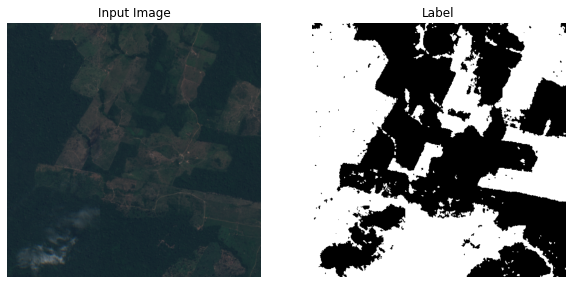

In [ ]:
num_sample = 1
n = 0
# print(train_image_generator.shape)
for image, mask in sample_generator:
    sample_image, sample_label = image[0], mask[0]
    if n < num_sample:
        display([sample_image, create_mask(sample_label)])
        n+=1
    else:
        break

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [ ]:
def fcn(image_size, ch_in=3, ch_out=1, drop_rate=0):
  inputs = Input(shape=(*image_size, ch_in), name='input')

  # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
  vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
  # Recovering the feature maps generated by each of the 3 final blocks:
  f3 = vgg16.get_layer('block3_pool').output
  f4 = vgg16.get_layer('block4_pool').output
  f5 = vgg16.get_layer('block5_pool').output

  conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(f5)
  conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)

  conv_8 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_8")(f4)
  conv_9 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_9")(f3)

  deconv_7 = Conv2DTranspose(1024, kernel_size=(2,2), strides=(2,2))(f5)
  add_1 = Add()([deconv_7, conv_8])

  outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=16,
  padding='same', activation="sigmoid")(add_1)


  fcn_model = Model(inputs, outputs)
  return fcn_model

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    intersect = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    fsum = K.sum(y_true,[1,2])
    ssum = K.sum(y_pred,[1,2])
    dice = (2 * intersect + smooth) / (fsum + ssum + smooth)
    dice = K.mean(dice)
    return dice  

def iou_coef(y_true, y_pred, smooth=0.0001):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon() + smooth) / (union + K.epsilon() + smooth ))

In [ ]:
# defining the tensorflow distribute strategy
strategy = tf.distribute.MirroredStrategy()

In [ ]:
# # calling the model inside the scope
with strategy.scope():
  model = fcn(image_size=(img_dim, img_dim))
  # compiling the model with the optimizer, loss function and acc metrics
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[iou_coef,dice_coef,'accuracy', 'mse'])

58889256/58889256 [==============================] - 0s 0us/step


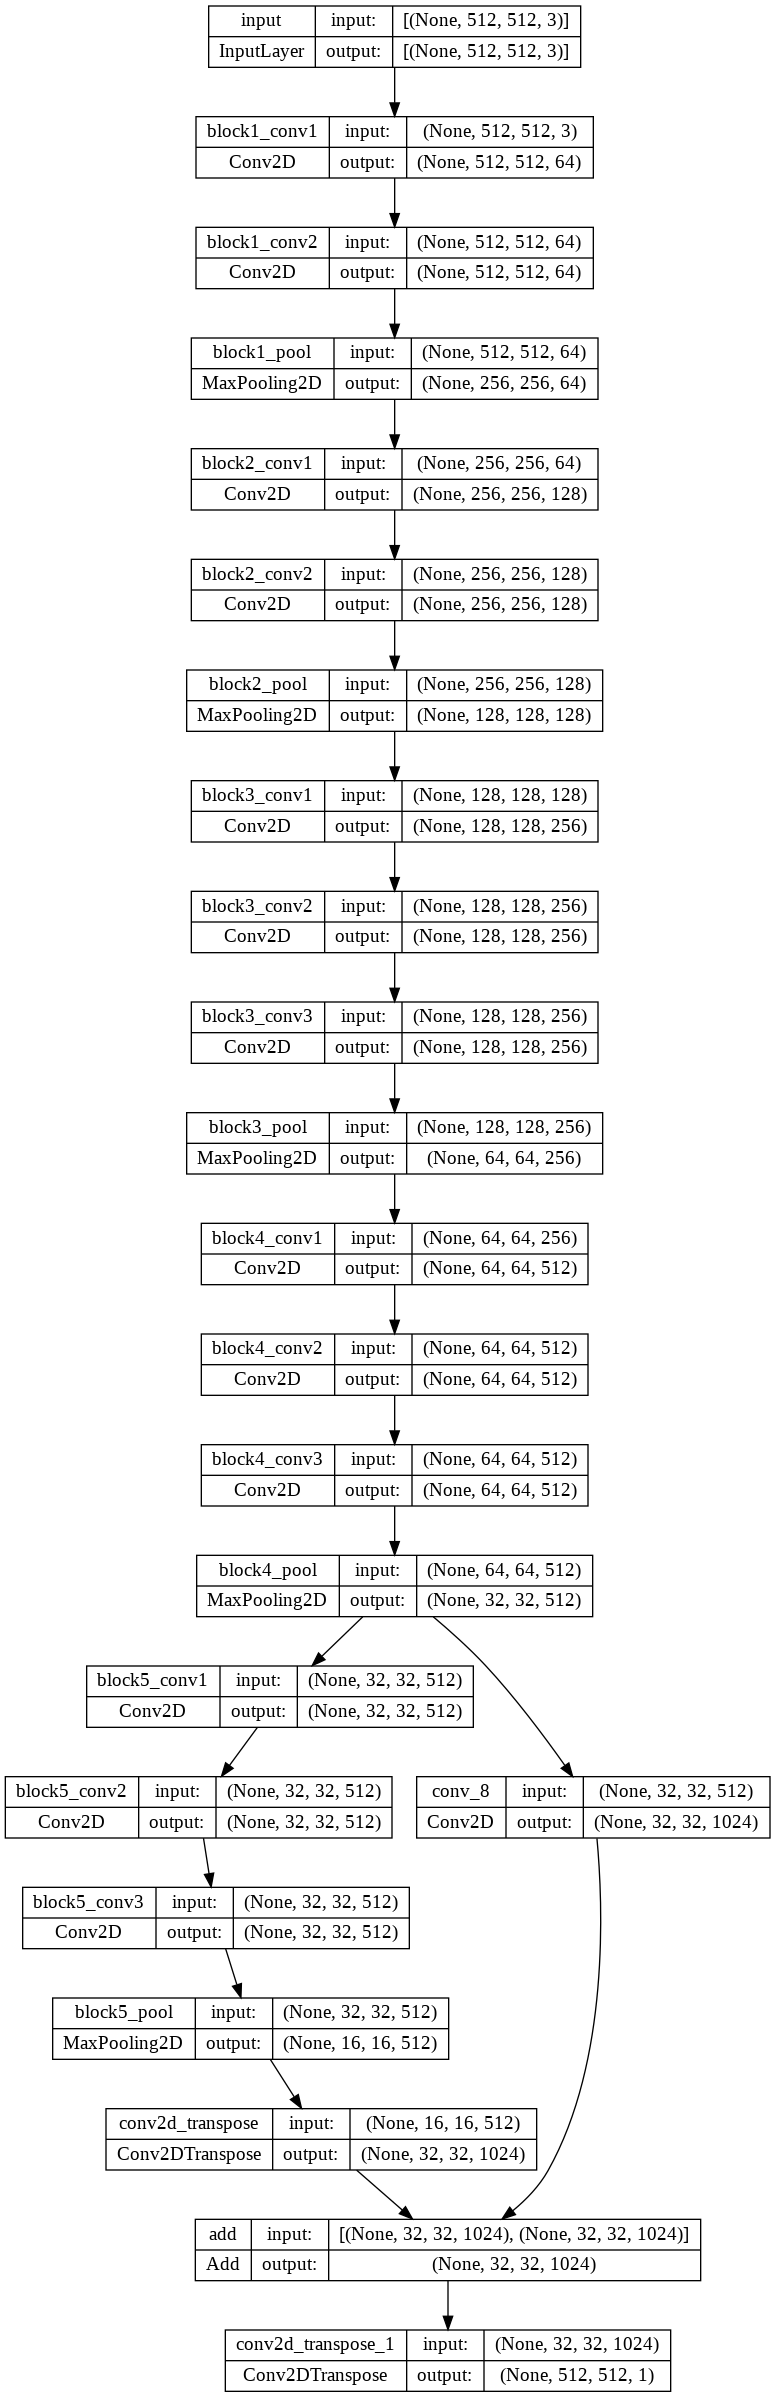

In [ ]:
# let's see how our FCN implemented model looks like
# does it looks like the architecture fig above?
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    n = 0
    for image, mask in dataset:
      image, mask = image, mask
      if n < num:
        # print(f'image shape {image.shape}')
        # print(f'mask shape {mask.shape}')
        # pred_mask = model.predict(image)
        result = model.predict(image)
        output = result[0]
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        print(f'image shape {image.shape}')
        print(f'mask shape {mask.shape}')
        print(f'pred_mask shape {output.shape}')
        display([image[0],mask[0].reshape(img_dim, img_dim), create_mask(output)])
        n+=1
      else:
        break
  else:
    prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    output = prediction[0]
    output[output >= 0.5] = 1
    output[output < 0.5] = 0
    display([sample_image, create_mask(sample_label), output])

    # # function to show the prediction
# def show_predictions(dataset=None, num=1):
#   if dataset:
#     n = 0
#     for image, mask in dataset:
#       image, mask = image, mask
#       if n < num:
#         pred_mask = model.predict(image)
#         print(f'image shape {image.shape}')
#         print(f'mask shape {mask.shape}')
#         print(f'pred_mask shape {pred_mask.shape}')
#         display([image[0], mask[0],pred_mask[0]])
#         n+=1
#       else:
#         break
#   else:
# #     prediction = model.predict(sample_image[tf.newaxis, ...])
# #     display([sample_image, sample_label, prediction[0]])

# def show_predictions(dataset=None, num=1):
#   if dataset:
#     n = 0
#     for image, mask in dataset:
#       image, mask = image, mask
#       if n < num:
#         # pred_mask = model.predict(image)
#         # print(pred_mask)
#         result = model.predict(image)
#         output = result[0]
#         output[output >= 0.5] = 1
#         output[output < 0.5] = 0
#         print(f'image shape {image.shape}')
#         print(f'mask shape {mask.shape}')
#         print(f'pred_mask shape {result.shape}')
#         display([image[0], mask[0], output])
#         n+=1
#       else:
#         break
#   else:
#     result = model.predict(sample_image[tf.newaxis, ...])
#     output = result[0]
#     output[output >= 0.5] = 1
#     output[output < 0.5] = 0
#     display([sample_image, sample_label, output])

1/1 [==============================] - 0s 65ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (512, 512, 1)


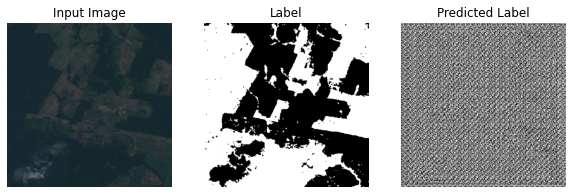

In [ ]:
# # Let's see a sample of input image it's true mask and what our model is predicted given the input image
show_predictions(sample_generator)

In [ ]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1)


In [ ]:
# defining some hyperparameters
TRAIN_LENGTH = 257
#128
STEPS_PER_EPOCH = 100

EPOCHS = 50
VAL_SUBSPLITS = 5
TEST_SIZE=15
VALIDATION_STEPS = TEST_SIZE//BATCH_SIZE#//VAL_SUBSPLITS

model_history = model.fit(train_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_generator,
                          callbacks=[early_stopping, reduce_lr]
                          )

Epoch 1/50
100/100 [==============================] - 13s 135ms/step - loss: 0.3191 - iou_coef: 0.7318 - dice_coef: 0.8141 - accuracy: 0.8626 - mse: 0.0912 - val_loss: 0.4390 - val_iou_coef: 0.4315 - val_dice_coef: 0.5630 - val_accuracy: 0.7893 - val_mse: 0.1467 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 15s 148ms/step - loss: 0.3053 - iou_coef: 0.7231 - dice_coef: 0.8066 - accuracy: 0.8624 - mse: 0.0845 - val_loss: 0.2880 - val_iou_coef: 0.7394 - val_dice_coef: 0.8345 - val_accuracy: 0.8908 - val_mse: 0.0850 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - 13s 130ms/step - loss: 0.2347 - iou_coef: 0.7922 - dice_coef: 0.8661 - accuracy: 0.8930 - mse: 0.0615 - val_loss: 0.2374 - val_iou_coef: 0.8394 - val_dice_coef: 0.9032 - val_accuracy: 0.9229 - val_mse: 0.0645 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - 13s 130ms/step - loss: 0.2548 - iou_coef: 0.7986 - dice_coef: 0.8704 - accuracy: 0.8899 - mse: 0.0670 - va

In [ ]:
model.evaluate(val_generator, steps=15)

15/15 [==============================] - 1s 40ms/step - loss: 0.2666 - iou_coef: 0.7463 - dice_coef: 0.8303 - accuracy: 0.9024 - mse: 0.0750


[0.2665832042694092,
 0.7462670803070068,
 0.8303490877151489,
 0.9024152159690857,
 0.07499894499778748]

1/1 [==============================] - 0s 64ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (512, 512, 1)


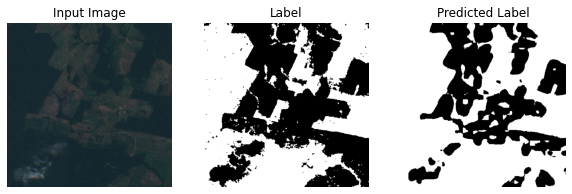

In [ ]:
show_predictions(sample_generator)

1/1 [==============================] - 0s 69ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (512, 512, 1)


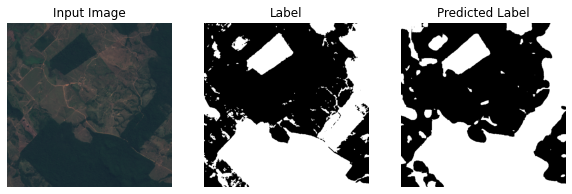

1/1 [==============================] - 0s 72ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (512, 512, 1)


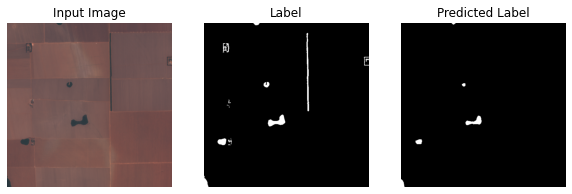

1/1 [==============================] - 0s 67ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (512, 512, 1)


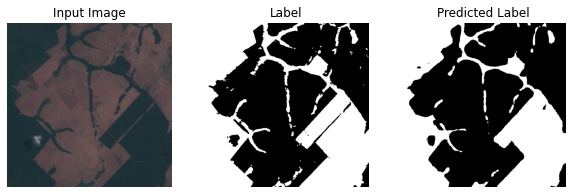

1/1 [==============================] - 0s 93ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (512, 512, 1)


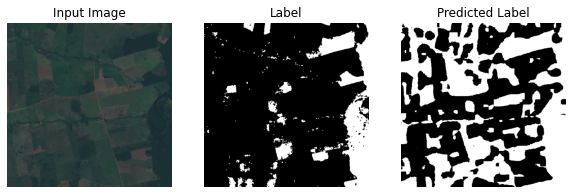

1/1 [==============================] - 0s 65ms/step
image shape (1, 512, 512, 3)
mask shape (1, 512, 512, 1)
pred_mask shape (512, 512, 1)


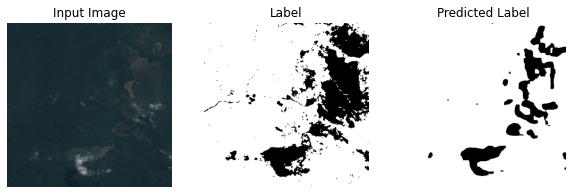

In [ ]:
show_predictions(val_generator, 5)

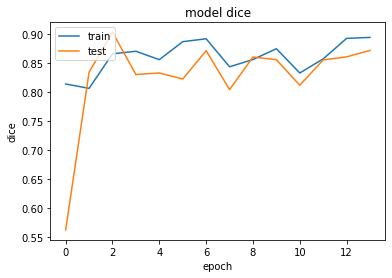

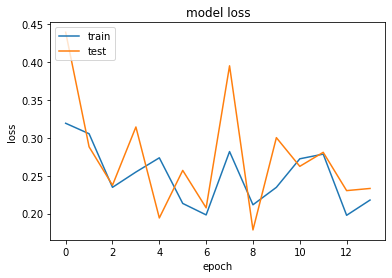

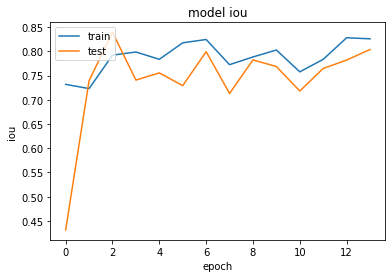

In [ ]:
#dice
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#iou
plt.plot(model_history.history['iou_coef'])
plt.plot(model_history.history['val_iou_coef'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('fcn-32s-c1-iou-norm.h5')